<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ot_2d_rotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* study how Wasserstein distance depends on molecular orientation in 2D

# Resources
* Rao, R., Moscovich, A., & Singer, A. (2020). Wasserstein K-Means for Clustering Tomographic Projections, (2016), 1–11.

# Setup

In [2]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')
import numba
import pandas as pd


In [3]:
!pip install pot
import ot

     |████████████████████████████████| 430kB 5.5MB/s 


In [222]:
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 51kB 2.4MB/s 


# Rotation of eliptical ($\sigma_{yx} \neq 0$) Gaussians

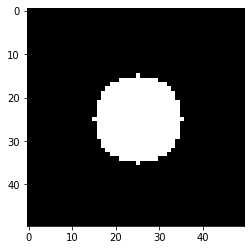

In [4]:
def create_circular_mask(N, radius=None, center=None):
  # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    h,w = N,N
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

doplt(create_circular_mask(50,10))

In [5]:
x, y = np.mgrid[-1:1:.025, -1:1:.025]
pos = np.dstack((x, y))
pos.shape # grid of 200x200 xy coordinates between -1 and 1

(80, 80, 2)

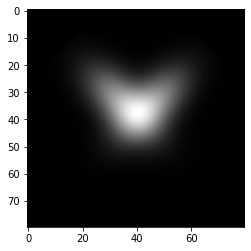

In [6]:
mu=1
rv = multivariate_normal(mean=[0,0], cov=np.array([[2.0, 0], [0, 0.5]]))
g1 = rv.pdf(5*pos+ np.array([mu,0]))
g2 = rv.pdf(5*pos+ np.array([-mu,-0]))
g1_rot = rotate(g1 ,angle=45,reshape=False)
g2_rot = rotate(g1,angle=-45,reshape=False)
I_2d = g1_rot+g2_rot
N=I_2d.shape[0]
mask = create_circular_mask(N,radius=N/2.1)
I_2d[~mask] = 0
doplt(I_2d)

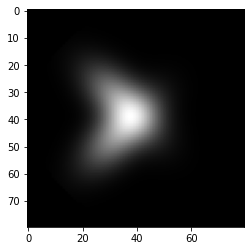

In [ ]:
I1 = rotate(I_2d,angle=+90,reshape=False)
doplt(I1)


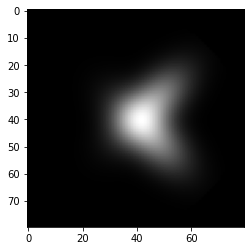

In [ ]:
I2 = rotate(I_2d,angle=-90,reshape=False)
doplt(I2)

# Wasserstein vs L2 distance at different rotations

## Cost

In [7]:
@numba.jit
def make_C_from_pos(pos_flat):
  N2 = pos_flat.shape[0]
  C = np.empty((N2,N2))
  np.fill_diagonal(C,0)
  for i in range(C.shape[0]):
    for j in range(i,C.shape[1]):
      C[i,j] = np.sqrt(((pos_flat[i] - pos_flat[j])**2).sum())
      C[j,i] = C[i,j]

  return(C)

In [8]:
%%time
C = make_C_from_pos(pos[mask])
C /= C.max()


CPU times: user 3.11 s, sys: 131 ms, total: 3.24 s
Wall time: 3.33 s


In [9]:
C.shape

(4569, 4569)

In [13]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
W = np.zeros(num_angles)
L2 = np.zeros_like(W)


for angle_idx, angle in enumerate(angles):
  print(angle,)
  I1 = rotate(I_2d,angle=angle/2,reshape=False)
  I2 = rotate(I_2d,angle=-angle/2,reshape=False)
  I1_flat = I1[mask]
  I1_flat /= I1_flat.sum()
  I2_flat = I2[mask]
  I2_flat /= I2_flat.sum()
  W[angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.5)
  L2[angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


0.0
9.473684210526315
18.94736842105263
28.421052631578945
37.89473684210526
47.368421052631575
56.84210526315789
66.3157894736842
75.78947368421052
85.26315789473684
94.73684210526315
104.21052631578947
113.68421052631578
123.1578947368421
132.6315789473684
142.10526315789474
151.57894736842104
161.05263157894734
170.52631578947367
180.0


Text(0, 0.5, 'W distance')

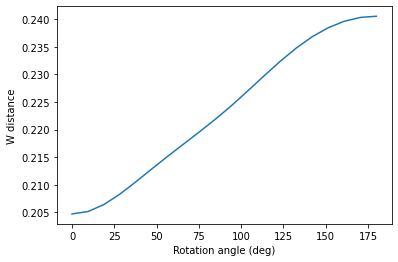

In [11]:
sr = pd.Series(W)
sr.index = angles
ax = sr.plot()
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Text(0, 0.5, 'L2 distance')

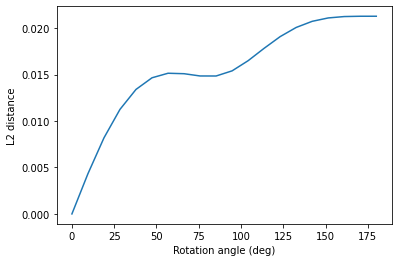

In [14]:
sr = pd.Series(L2)
sr.index = angles
ax = sr.plot()
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('L2 distance')

We see that the W distance is increasing (monotonically) as the angle does. This makes sense. 

Let's see how things change where there is some noise.

0.003
0.01
0.03
0.1
0.3


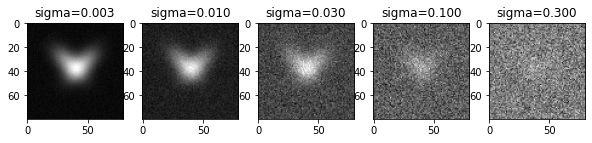

In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
sigmas = [0.003,.01, 0.03,0.1,0.3]
W = np.zeros((len(sigmas),num_angles))
L2 = np.zeros_like(W)
fig, axes = plt.subplots(ncols=len(sigmas),figsize=(10,10))

for sigma_idx, sigma in enumerate(sigmas):
  print(sigma)
  noise = np.random.normal(loc=0*I_2d,scale=sigma)
  axes[sigma_idx].imshow(I_2d+noise,cmap='gray')
  axes[sigma_idx].set_title('sigma=%.3f'%sigma)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    W[sigma_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1)
    L2[sigma_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


In [ ]:
def rownorm_01(arr2d):
  arr2d -= arr2d.min(1).reshape(-1,1)
  arr2d /= arr2d.max(1).reshape(-1,1)
  return(arr2d)

Text(0, 0.5, 'L2 distance')

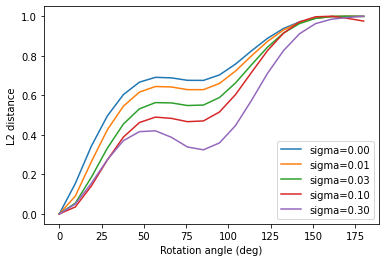

In [ ]:
L2_01 = rownorm_01(L2.copy())
for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(L2_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('L2 distance')

Text(0, 0.5, 'W distance')

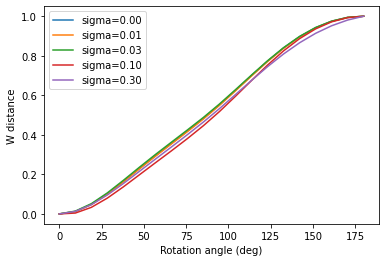

In [ ]:
W_01 = rownorm_01(W.copy())

for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(W_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

In the EM update, the L2 distances are weighed by a Baysean factor (when combining the contribution of each image in each pixel). The Baysian weight for an image $X_i$, with resspect to template $A$ is $\gamma(\theta) = \sim \exp -\sum_\alpha \frac{X_{i\alpha}-A_{\alpha}(\theta)}{2 \sigma^2}$, where $\theta$ is the latent variable(s) that are averaged over in the Baysean setting (e.g. rotations and shifts). Things work out, if there is more noise, then sigma is higher and weightings are smoothed out. The value of $\sigma$ changes $\gamma$ in a non-linear way, and this can't be seen in the above plots.

It's not clear what exactly to do with the Wp, in order to turn them into Baysean weights.

Now that we see that the W distance is more sensitive to noise, compared with the L2 distance.

Perhaps the regularization parameter can help this.

Let's look at a protein example now, which has all sorts of fine detail, compared with our gaussian blob toy example.

In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
regs = [0.05,0.1,0.5,1]
sigma = 0.3
W = np.zeros((len(regs),num_angles))
L2 = np.zeros_like(W)
noise = np.random.normal(loc=0*I_2d,scale=sigma)

for reg_idx, reg in enumerate(regs):
  print(reg)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    W[reg_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=reg,numItermax=10**5)
    L2[reg_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


0.05
0.1
0.5
1


Text(0, 0.5, 'W distance')

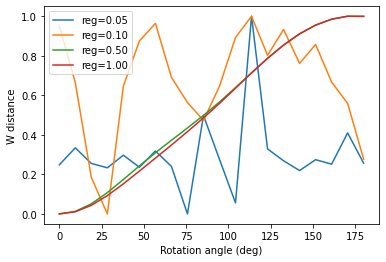

In [106]:
W_01 = rownorm_01(W.copy())

for reg_idx, reg in enumerate(regs):
  sr = pd.Series(W_01[reg_idx,:])
  sr.index = angles
  ax = sr.plot(label='reg=%.2f'%reg,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

In [104]:
for numItermax in [10**3,10**4,10**5]:
  print(numItermax,ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1,numItermax=numItermax))


1000 [0.16920093]
10000 [-0.13617646]
100000 [-0.13617646]


In [105]:
for numItermax in [10**3,10**4,10**5]:
  print(numItermax,ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.5,numItermax=numItermax))

1000 [0.2383865]
10000 [0.2383865]
100000 [0.2383865]


We can see the issues with numerical convergence in the above two examples. We get differente values when reg is too small.

How do we pick a good regularization? And what exactly does it control? If different regs give the same Wp curve, then they will not affect how the template is updated, just computational efficiency. When it is too high or too low, is there pathalogical behaviour? Perhaps 
- numerical issues when it is too low (or it takes too long when using more expensive methods, or more iterations)?
- doesn't recapitulate the right ground truth angle when too high/low.
  - NB: `method='sinkhorn_epsilon_scaling'` is much slower, but can't get working with ot.sinkhorn2 (shape bug)
- need more iterations for lower `reg` (e.g. `numIterMax=10**5` for `reg=0`.05, and `10**4` for `reg=0.1`)

# Bayesian weights

In order to use Wp in a the famiar expectation-maximization setting, we need Bayesian weights on the nusance parameters (shift, rotation, CTF?). 

The Bayesian weight should be some (unknown now) function, $f$, of $W_p(X,A)$. My intuition suggests that the forward model should depend on the transport matrix (not just gaussian additive noise), in such a way that the probability of the template A, given the data X is maximized under A (q are the latent variables): 
$$L = \ln p(A|\text{data}) = \sum_i \int dq \ \gamma(q,A,X_i) \\
A_* =  \underset{A}{\arg\max} \ L
$$

In any basic forward model (not just Gaussian additive) $p(A|\text{data}) = p(\text{data}|A)p(A)/p(\text{data})$ by Bayes, and $p(\text{data}|A) = \prod_i p(X_i|A)$. Assuming each pixel $a$ is iid, we have $p(X_i|A)=\prod_a p(X_{ia}|A)$. However, if we are using $W_p$ to model the distance, is this assumption valid? It depends on our forward model. But what is our forward model? We should chose it such that we recover $\gamma(q,A,X_i) = f(W_p(X_i,A))$; where either $X_i$ or $A$ incorporates the latent variable. If we can get $\gamma=f(W_p)$ from $p(X_i|A)$, we don't need to do the per pixel iid decomposition.



In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
W = np.zeros(num_angles)
L2 = np.zeros_like(W)


for angle_idx, angle in enumerate(angles):
  print(angle,)
  I1 = rotate(I_2d,angle=angle/2,reshape=False)
  I2 = rotate(I_2d,angle=-angle/2,reshape=False)
  I1_flat = I1[mask]
  I1_flat /= I1_flat.sum()
  I2_flat = I2[mask]
  I2_flat /= I2_flat.sum()
  W[angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.5)
  L2[angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


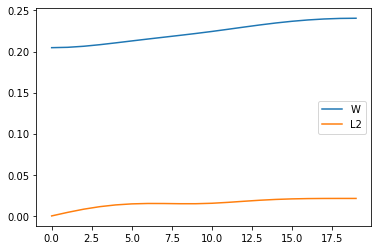

In [16]:
pd.Series(W).plot(label='W',legend=True)
pd.Series(L2).plot(label='L2',legend=True)

Even at zero noise, Wp is still not at zero at the perfect alignment angle, because of the reg term.

Let's introduce some noise, so gamma for L2 doesn't blow up

0.0
9.473684210526315
18.94736842105263
28.421052631578945
37.89473684210526
47.368421052631575
56.84210526315789
66.3157894736842
75.78947368421052
85.26315789473684
94.73684210526315
104.21052631578947
113.68421052631578
123.1578947368421
132.6315789473684
142.10526315789474
151.57894736842104
161.05263157894734
170.52631578947367
180.0


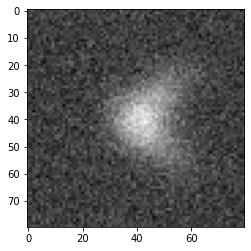

In [111]:
sigma = 0.03

noise = np.random.normal(loc=0*I_2d,scale=sigma)
num_angles = 20
angles = np.linspace(0,180,num_angles)
W = np.zeros(num_angles)
L2 = np.zeros_like(W)
reg=0.5
for angle_idx, angle in enumerate(angles):
  print(angle,)
  I1 = rotate(I_2d,angle=angle/2,reshape=False)
  I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
  I1_flat = I1[mask]
  I1_flat /= I1_flat.sum()
  I2_flat = I2[mask]
  I2_flat /= I2_flat.sum()
  W[angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=reg)
  L2[angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())

doplt(I2)

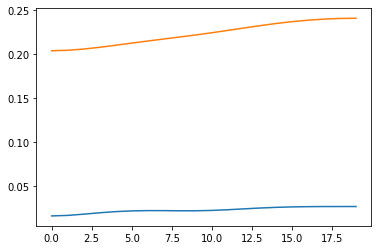

In [112]:
pd.Series(L2).plot()
g_W = W
pd.Series(g_W).plot()

Note that L2 is importantly not at zero at the best angle (now there is noise, so there is an important non zero value here that expressed some lack of confidence).

Wp is actually on the same scale as L2, but we should be careful to completely shift it down down by its minimum (best alignment), since that might express too much confidence, depending on how it is later transformed. The range is a bit larger, and perhaps should be scaled by reg somehow.

It makes sense that if reg is increased, we are less sure of our optimal plan, and the alignment landscape should smooth out (less of a range)

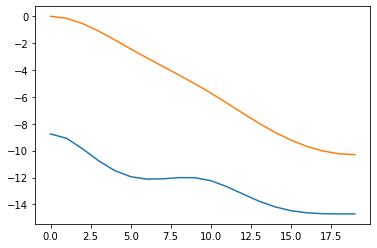

In [113]:
g_L2 = ((-L2/(2*sigma**2)))
pd.Series(g_L2).plot()
g_W = (-(W - W.min())*0.5/(2*sigma**2))
pd.Series(g_W).plot()



The absolute zero value of Wp at the best angle makes it dominate when exp-ed. Note the first value of `g_L2` vs `g_W`.

In [114]:
L2

array([0.01576117, 0.01634622, 0.017758  , 0.01935601, 0.02066743,
       0.0214889 , 0.02181511, 0.02177659, 0.02161392, 0.02162342,
       0.02202203, 0.02281232, 0.02380171, 0.02475655, 0.02552074,
       0.02603899, 0.02632797, 0.02644699, 0.02647312, 0.02647456])

In [115]:
g_L2

array([ -8.75620598,  -9.08123428,  -9.86555713, -10.75333999,
       -11.48190439, -11.93827856, -12.11950443, -12.09810463,
       -12.00773345, -12.01301063, -12.23446366, -12.67351272,
       -13.22317439, -13.75364147, -14.17818868, -14.46610549,
       -14.62665077, -14.69277008, -14.70728869, -14.70808783])

In [116]:
g_W

array([ -0.        ,  -0.15560973,  -0.54591719,  -1.104697  ,
        -1.75301301,  -2.4287778 ,  -3.08868418,  -3.72728876,
        -4.36470425,  -5.01656286,  -5.71228872,  -6.45492288,
        -7.21267264,  -7.95218966,  -8.6325423 ,  -9.21692111,
        -9.68470738, -10.02411911, -10.23049098, -10.30175229])

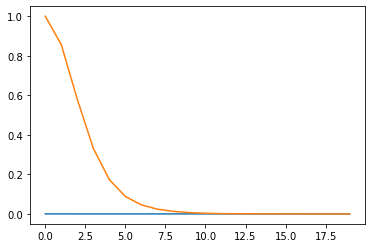

In [117]:
g_L2 = np.exp((-L2/(2*sigma**2)))
pd.Series(g_L2).plot()
g_W = np.exp(-(W - W.min())*0.5/(2*sigma**2))
pd.Series(g_W).plot()



This is precicely what we want to avoid... perhaps through introducing some offset value (that depends on reg and sigma somehow?)

Perhaps the easiest thing to do is to use the L2 estimate at the best angle. We are using the Wp in an L2 manner anyway

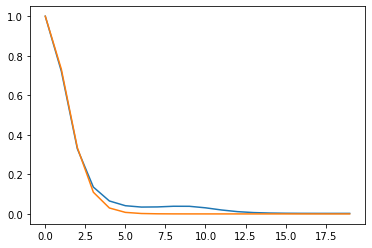

In [118]:
arg = (-L2/(2*sigma**2))
g_L2 = np.exp(arg-arg.max())
pd.Series(g_L2).plot()
best_L2 = L2.min()
arg = -(W - W.min()+best_L2)/(2*sigma**2)
g_W = np.exp(arg-arg.max())
pd.Series(g_W).plot()



0.5
1
2


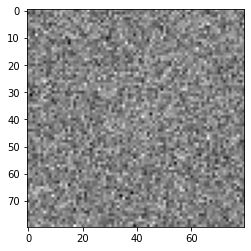

In [217]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
regs = [0.5,1,2]
sigma = 1
W = np.zeros((len(regs),num_angles))
L2 = np.zeros_like(W)
noise = np.random.normal(loc=0*I_2d,scale=sigma)
doplt(I_2d+noise)

for reg_idx, reg in enumerate(regs):
  print(reg)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    W[reg_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=reg,numItermax=10**5)
    L2[reg_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())

Text(0, 0.5, 'gamma')

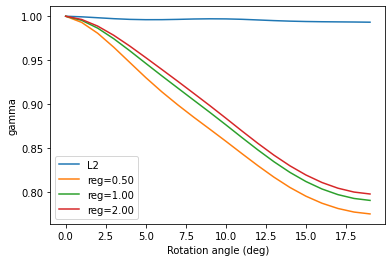

In [203]:
arg = (-L2[0,:]/(2*sigma**2)) # reg as no effect on L2, all the same
g_L2 = np.exp(arg-arg.max())
pd.Series(g_L2).plot(label='L2',legend=True)

for reg_idx, reg in enumerate(regs):
  best_L2 = L2[reg_idx,:].min()
  arg = -(W[reg_idx,:] - W[reg_idx,:].min()+best_L2)/(2*sigma**2)
  g_W = np.exp(arg-arg.max())
  ax=pd.Series(g_W).plot(label='reg=%.2f'%reg,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('gamma')

We see that this L2 like way of scaling Wp get rid of the scaling from reg, which we likely want, because it does scale Wp in a principled way.

Text(0, 0.5, 'W distance')

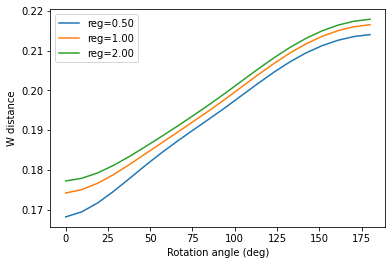

In [198]:
for reg_idx, reg in enumerate(regs):
  sr = pd.Series(W[reg_idx,:])
  sr.index = angles
  ax = sr.plot(label='reg=%.2f'%reg,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Text(0, 0.5, 'gamma = f(W)')

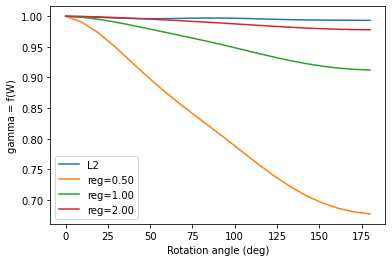

In [216]:
arg = (-L2[0,:]/(2*sigma**2)) # reg as no effect on L2, all the same
g_L2 = np.exp(arg-arg.max())
sr = pd.Series(g_L2)
sr.index = angles
sr.plot(label='L2',legend=True)

for reg_idx, reg in enumerate(regs):
  arg = -W[reg_idx,:]**2/(reg**2*2*sigma**2)
  g_W = np.exp(arg - arg.max())
  sr = pd.Series(g_W)
  sr.index = angles
  ax = sr.plot(label='reg=%.2f'%reg,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('gamma = f(W)')

A good candidate for $\gamma(W_1)$ is $\exp\frac{-W_1^{C_1}}{\epsilon^{C_2}2\sigma^2}$, where $\epsilon$ is the reg param and C1 and C2 are constants. Perhaps they can be determined by testing over a range of sigmas and seeing if $\gamma(L2)$ and $\gamma(W)$ are in the same range (with reg adjusting the sensitivity above/below that of L2. Using this approach, $\sigma^2$ was chosen over $\sigma$.

# Particle
Finally, let's compare on a particle example

## Data

In [ ]:
%%bash
wget ftp://ftp.wwpdb.org/pub/emdb/structures/EMD-7978/map/emd_7978.map.gz # sometimes this takes too long, and is completed but looks like it is still running

In [220]:
%%bash
gunzip emd_7978.map.gz  # sometimes this takes too long, and is completed but looks like it is still running

In [223]:
f = mrcfile.open('emd_7978.map')
map = f.data
f.close()
N = map.shape[0]

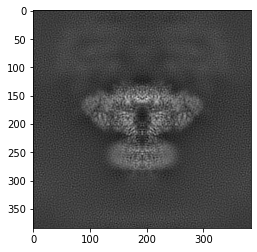

In [226]:
doplt(map.sum(1))

Let's downsample the particle to speed up out computation

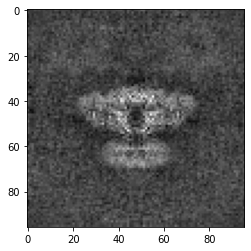

In [260]:
from scipy import ndimage
map_zoom = ndimage.zoom(map.sum(1),zoom=0.25)
doplt(map_zoom)

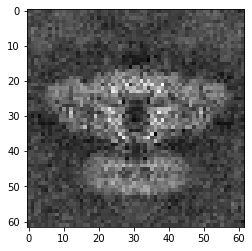

In [261]:
unpad_factor = .18
unpad = int(map_zoom.shape[0]*unpad_factor)
map_window = map_zoom[unpad:-unpad,unpad:-unpad]
doplt(map_window)

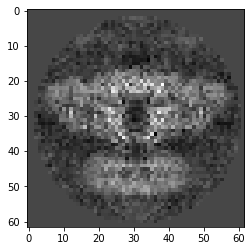

In [262]:
image = map_window.copy()
N = image.shape[0]
mask = create_circular_mask(N,radius=N/2.1)
image[~mask]=0
image /= image[mask].max()
doplt(image)

## Wp

Cost

In [263]:
xv, yv = np.meshgrid(np.arange(N),np.arange(N), sparse=False, indexing='ij')
pos = np.dstack((xv, yv))
C = make_C_from_pos(pos[mask])
C /= C.max()

0.03
0.1
0.3
1


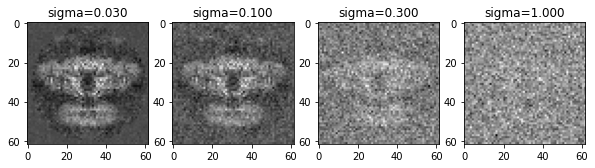

In [268]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
sigmas = [.03,.1,.3,1]
W = np.zeros((len(sigmas),num_angles))
L2 = np.zeros_like(W)
fig, axes = plt.subplots(ncols=len(sigmas),figsize=(10,10))
reg=0.5
for sigma_idx, sigma in enumerate(sigmas):
  print(sigma)
  noise = np.random.normal(loc=0*image,scale=sigma)
  axes[sigma_idx].imshow(image+noise,cmap='gray')
  axes[sigma_idx].set_title('sigma=%.3f'%sigma)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(image,angle=angle/2,reshape=False) 
    I2 = rotate(image,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    W[sigma_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=reg)
    L2[sigma_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


Text(0, 0.5, 'L2 distance')

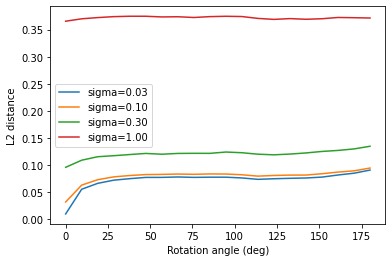

In [269]:
for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(L2[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('L2 distance')

Text(0, 0.5, 'W distance')

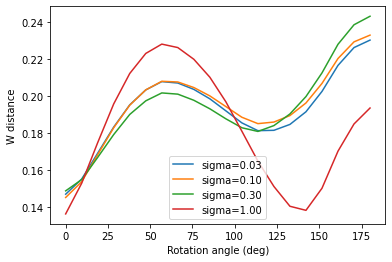

In [270]:
for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(W[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Text(0, 0.5, 'gamma')

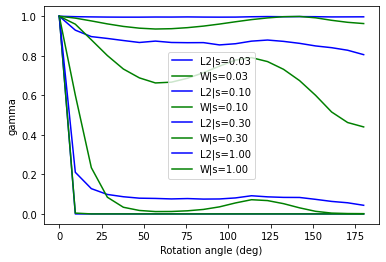

In [279]:
reg=0.5
for sigma_idx, sigma in enumerate(sigmas):

  arg = (-L2[sigma_idx,:]/(2*sigma**2)) # reg as no effect on L2, all the same
  g_L2 = np.exp(arg-arg.max())
  sr = pd.Series(g_L2)
  sr.index = angles
  sr.plot(label='L2|s=%.2f'%sigma,legend=True,color='b')

  arg = -W[sigma_idx,:]**2/(reg**2*2*sigma**2)
  g_W = np.exp(arg - arg.max())
  sr = pd.Series(g_W)
  sr.index = angles
  ax = sr.plot(label='W|s=%.2f'%sigma,legend=True,color='g')
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('gamma')